In [1]:
! wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
! tar -xvf /content/drive/My\ Drive/project2/food-101.tar.gz > /dev/null 2>&1

/bin/bash: /home/mca/anaconda3/envs/dse/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2024-10-23 08:22:32--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-10-23 08:22:33--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  12.9MB/s    in 6m 15s  

2024-10-23 08:28:48 (12.7 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

/bin/bash: /home/mca/anaconda3

In [4]:
!pip install scikit-image


/bin/bash: /home/mca/anaconda3/envs/dse/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [5]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

%matplotlib inline


In [6]:
import tarfile

# Path to the tar.gz file
tar_file_path = 'food-101.tar.gz'  # Adjust this if necessary

# Extract the tar file
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(path='./food-101')  # Specify the extraction directory

# Now list the contents of the extracted directory
food_extract_dir = './food-101'
for root, dirs, files in os.walk(food_extract_dir):
    print(f"Directory: {root}")
    print(f"Sub-directories: {dirs}")
    print(f"Files: {files}")
    print("-" * 50)


Directory: ./food-101
Sub-directories: ['food-101']
Files: []
--------------------------------------------------
Directory: ./food-101/food-101
Sub-directories: ['meta', 'images']
Files: ['README.txt', 'license_agreement.txt']
--------------------------------------------------
Directory: ./food-101/food-101/meta
Sub-directories: []
Files: ['test.txt', 'labels.txt', 'test.json', 'classes.txt', 'train.txt', 'train.json']
--------------------------------------------------
Directory: ./food-101/food-101/images
Sub-directories: ['cheese_plate', 'crab_cakes', 'waffles', 'spring_rolls', 'lasagna', 'breakfast_burrito', 'takoyaki', 'beignets', 'panna_cotta', 'bruschetta', 'club_sandwich', 'shrimp_and_grits', 'lobster_bisque', 'hot_and_sour_soup', 'hummus', 'paella', 'ramen', 'sashimi', 'chocolate_mousse', 'ceviche', 'fried_rice', 'guacamole', 'french_onion_soup', 'pancakes', 'beet_salad', 'chicken_wings', 'greek_salad', 'tiramisu', 'cheesecake', 'apple_pie', 'frozen_yogurt', 'lobster_roll_sandw

In [7]:
print(os.listdir())



['food-101', '.ipynb_checkpoints', 'food-101.tar.gz', 'untitiled (2).ipynb']


In [8]:
class_N = {}
N_class = {}
with open('food-101/food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map. 
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.  
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)
# Train files to ignore. 
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.    
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.  
def load_images(path_to_imgs):
  resize_count = 0
  
  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)
  
  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files. 
def gen_train_test_split(path_to_imgs = 'food-101/food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test

     

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [9]:
print(os.listdir('./food-101/food-101/meta/'))


['test.txt', 'labels.txt', 'test.json', 'classes.txt', 'train.txt', 'train.json']


In [10]:
import os

# Function to count lines in a file
def count_lines(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for line in file)

# Generate train-test files.
if not os.path.isdir('./food-101/food-101/test') and not os.path.isdir('./food-101/food-101/train'):
    gen_train_test_split()

len_train_file = './food-101/food-101/meta/train.txt'
len_test_file = './food-101/food-101/meta/test.txt'

if os.path.exists(len_train_file):
    len_train = count_lines(len_train_file)
else:
    print('train.txt not found.')

if os.path.exists(len_test_file):
    len_test = count_lines(len_test_file)
else:
    print('test.txt not found.')

print("train:",len_train, "test:",len_test)


train: 75750 test: 25250


In [11]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('food-101/food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Visulize the result

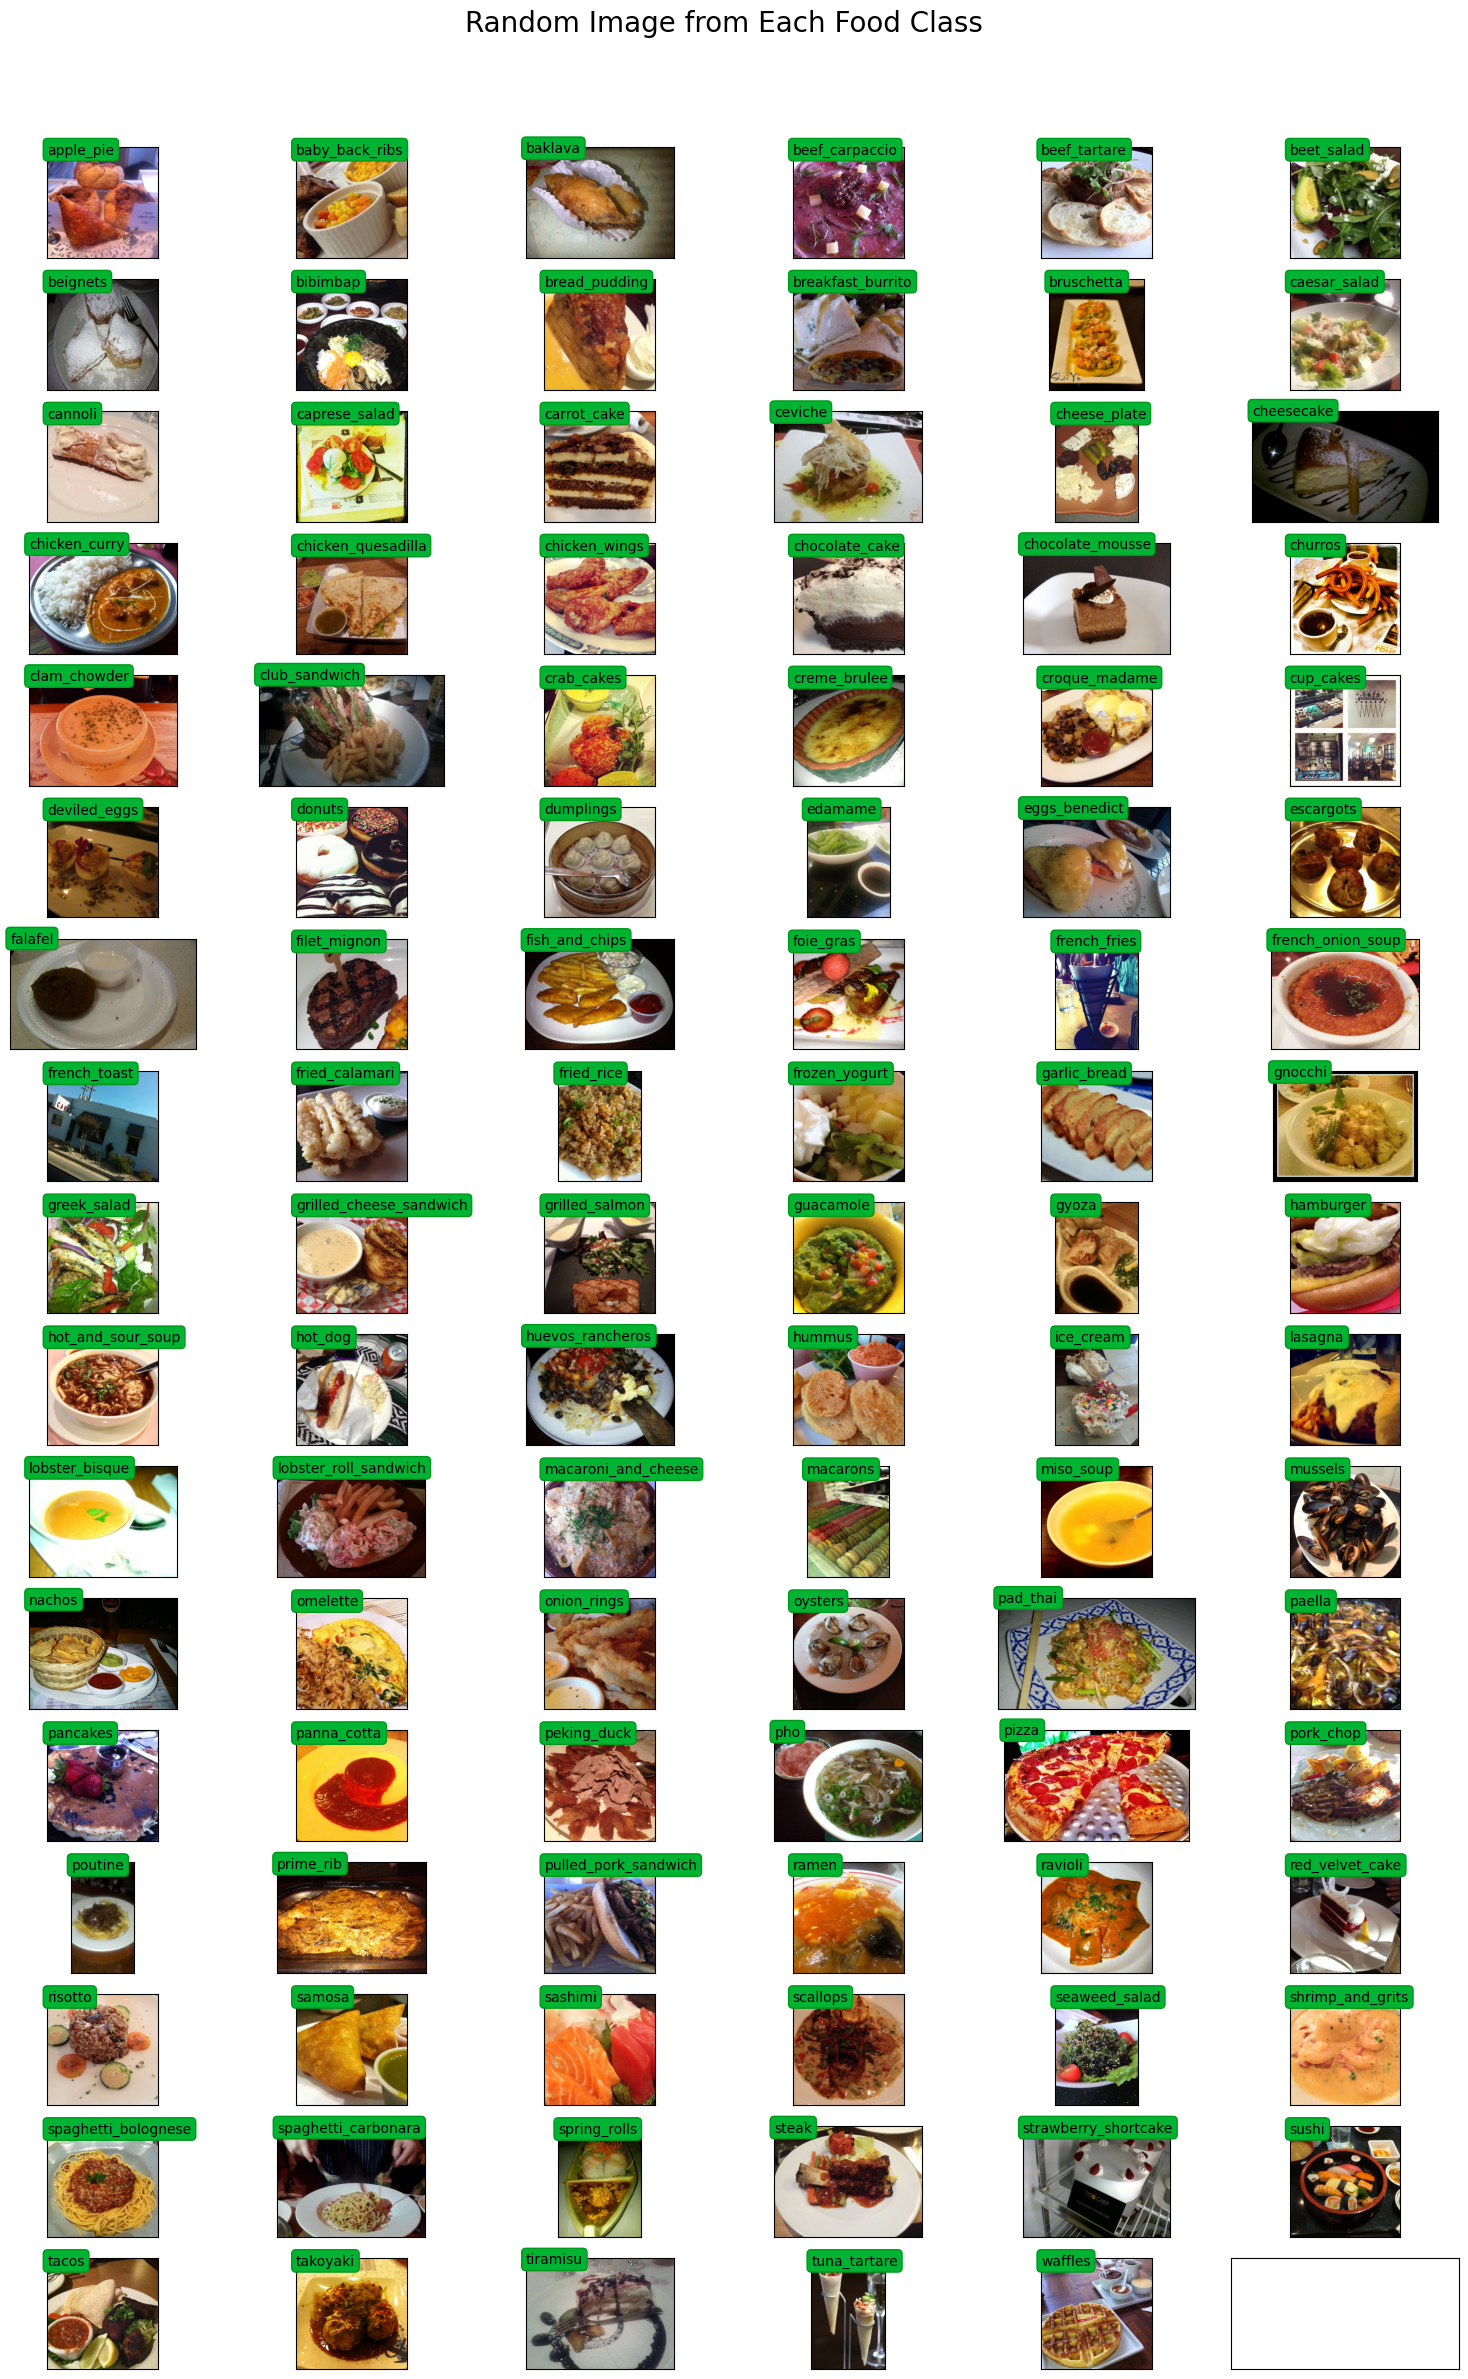

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Training data
root_dir = 'food-101/food-101/images/'  # Adjust this path as necessary
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)

sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i * cols + j]
        except IndexError:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                      ha="left", va="top",
                      bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()  # Make sure to call plt.show() to display the plot


Some prediction with test data set

In [13]:
import os

def load_train_test_data(train_file, test_file):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    # Load training data from the train.txt file
    with open(train_file, 'r') as f:
        train_lines = f.readlines()
        for line in train_lines:
            image_path = line.strip()  # Get rid of any extra spaces/newlines
            label = image_path.split('/')[0]  # Assuming the label is the first part of the path
            X_train.append(image_path)
            y_train.append(label)
    
    # Load testing data from the test.txt file
    with open(test_file, 'r') as f:
        test_lines = f.readlines()
        for line in test_lines:
            image_path = line.strip()
            label = image_path.split('/')[0]  # Assuming the label is the first part of the path
            X_test.append(image_path)
            y_test.append(label)

    return X_train, y_train, X_test, y_test

# Call the function with your paths
X_train, y_train, X_test, y_test = load_train_test_data(
    '/home/mca/220968372/food-101/food-101/meta/train.txt',
    '/home/mca/220968372/food-101/food-101/meta/test.txt'
)


In [14]:
print(os.path.abspath(len_train_file))
print(os.path.abspath(len_test_file))


/home/mca/220968372-2/food-101/food-101/meta/train.txt
/home/mca/220968372-2/food-101/food-101/meta/test.txt


In [15]:
X_train, y_train, X_test, y_test = load_train_test_data('/home/mca/220968372/food-101/food-101/meta/train.txt', '/home/mca/220968372/food-101/food-101/meta/test.txt')


Fitting the data on the Inception-v3 model.

In [16]:
import os
import shutil

def create_train_test_split(images_dir, meta_dir):
    train_dir = os.path.join(images_dir, 'train')
    test_dir = os.path.join(images_dir, 'test')

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    with open(os.path.join(meta_dir, 'train.txt'), 'r') as f:
        train_images = [line.strip() for line in f.readlines()]
    
    with open(os.path.join(meta_dir, 'test.txt'), 'r') as f:
        test_images = [line.strip() for line in f.readlines()]

    # Move images to train folder
    for img in train_images:
        class_name = img.split('/')[0]
        src = os.path.join(images_dir, img + '.jpg')
        dst_dir = os.path.join(train_dir, class_name)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        shutil.copy(src, dst_dir)

    # Move images to test folder
    for img in test_images:
        class_name = img.split('/')[0]
        src = os.path.join(images_dir, img + '.jpg')
        dst_dir = os.path.join(test_dir, class_name)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        shutil.copy(src, dst_dir)

# Call the function with appropriate directories
create_train_test_split('./food-101/food-101/images', './food-101/food-101/meta')

In [17]:
import os
import shutil

# Paths
base_dir = './food-101/food-101/'
images_dir = os.path.join(base_dir, 'images')
meta_dir = os.path.join(base_dir, 'meta')
train_file = os.path.join(meta_dir, 'train.txt')
test_file = os.path.join(meta_dir, 'test.txt')

# Directories to store train and test splits
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Function to create directories for train/test split
def create_split_dirs(target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for class_name in os.listdir(images_dir):
        class_dir = os.path.join(target_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

# Copy images listed in the txt file to corresponding directories
def copy_images(file_path, target_dir):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            img_path = line.strip() + '.jpg'
            class_name = img_path.split('/')[0]
            source = os.path.join(images_dir, img_path)
            destination = os.path.join(target_dir, class_name, os.path.basename(img_path))
            shutil.copy(source, destination)

# Create train and test directories with class subfolders
create_split_dirs(train_dir)
create_split_dirs(test_dir)

# Copy images from train.txt and test.txt to their respective directories
copy_images(train_file, train_dir)
copy_images(test_file, test_dir)

print("Images successfully split into train and test directories.")


Images successfully split into train and test directories.


1)Fitting the data on the Inception-v3 model.

In [18]:

# Clear any existing models in memory
tensorflow.keras.backend.clear_session()

# Constants
n_classes = 101  # Since Food-101 dataset has 101 classes
batch_size = 16
width, height = 200, 200
train_data = './food-101/train'  # Correct train directory
test_data = './food-101/test'    # Correct test directory
train_samples = 75750  # Number of training samples in Food-101 dataset
test_samples = 25250   # Number of test samples in Food-101 dataset

# Data augmentation for training, and rescaling for test
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

# Load images from the train and test directories
train_gen = train_data_gen.flow_from_directory(
    train_data,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_data_gen.flow_from_directory(
    test_data,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load InceptionV3 model without the top layer, and prepare it for training
inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)

# Final classification layer
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

# Define the full model
model = Model(inputs=inception.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to save the best model and log training history
checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

# Train the model
history_101class = model.fit(
    train_gen,
    steps_per_epoch=train_samples // batch_size,
    validation_data=test_gen,
    validation_steps=test_samples // batch_size,
    epochs=30,
    callbacks=[csv_logger, checkpointer]
)

# Save the final trained model
model.save('model_trained_101class.hdf5')


Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


2024-10-23 08:33:32.418178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 08:33:32.551856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 08:33:32.552335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/30


2024-10-23 08:33:40.372755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-23 08:33:42.273086: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x24a455f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-23 08:33:42.273147: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 08:33:42.462648: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4734/4734 [==============================] - ETA: 0s - loss: 4.9082 - accuracy: 0.0658

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4734/4734 [==============================] - 491s 101ms/step - loss: 4.9082 - accuracy: 0.0658 - val_loss: 4.1100 - val_accuracy: 0.2237
Epoch 2/30
4734/4734 [==============================] - 477s 101ms/step - loss: 3.8862 - accuracy: 0.2439 - val_loss: 2.8736 - val_accuracy: 0.4378
Epoch 3/30
4734/4734 [==============================] - 488s 103ms/step - loss: 3.1682 - accuracy: 0.3688 - val_loss: 2.3468 - val_accuracy: 0.5318
Epoch 4/30
4734/4734 [==============================] - 506s 107ms/step - loss: 2.7547 - accuracy: 0.4454 - val_loss: 2.0465 - val_accuracy: 0.5901
Epoch 5/30
4734/4734 [==============================] - 511s 108ms/step - loss: 2.4782 - accuracy: 0.5007 - val_loss: 1.8139 - val_accuracy: 0.6368
Epoch 6/30
4734/4734 [==============================] - 495s 105ms/step - loss: 2.2697 - accuracy: 0.5403 - val_loss: 1.6829 - val_accuracy: 0.6639
Epoch 7/30
4734/4734 [==============================] - 478s 101ms/step - loss: 2.1058 - accuracy: 0.5743 - val_loss: 1.572

In [25]:
class_map_101 = train_gen.class_indices
class_map_101

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

/tmp/ipykernel_5757/726071898.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


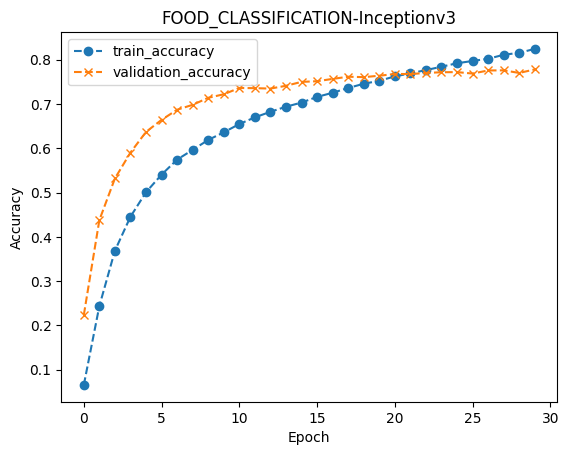

In [26]:
# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()
     


/tmp/ipykernel_5757/1691432128.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


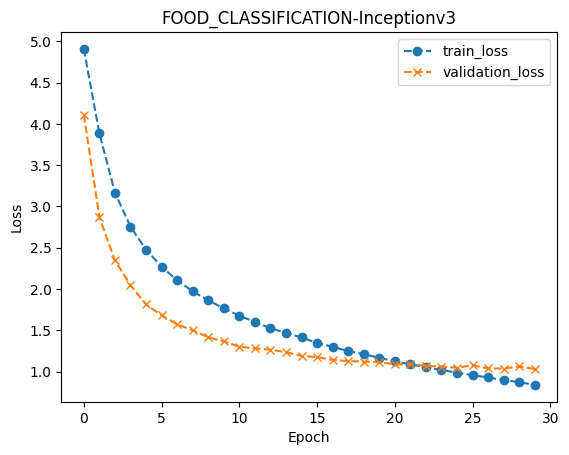

In [27]:
# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()
     

In [36]:
print(os.listdir())


['history_101class.log', 'food-101', '.ipynb_checkpoints', 'model_trained_101class.hdf5', 'strawberryshortcake.jpg', 'cupcakes.jpg', 'speghetticarbonara.jpg', 'garlicbread.jpg', 'frenchfries.jpg', 'pizza.jpg', 'food-101.tar.gz', 'best_model_101class.hdf5', 'untitiled (2).ipynb']


1/1 [==============================] - 1s 601ms/step


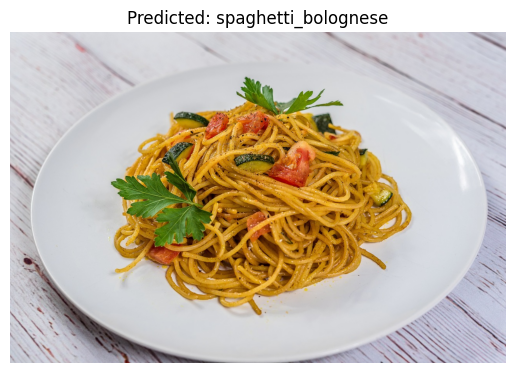

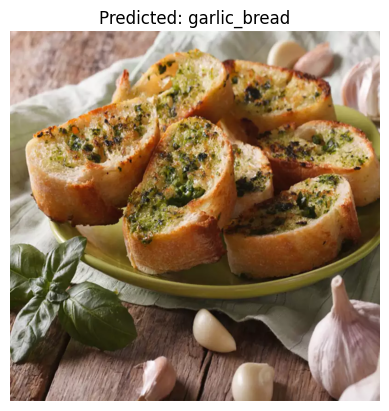

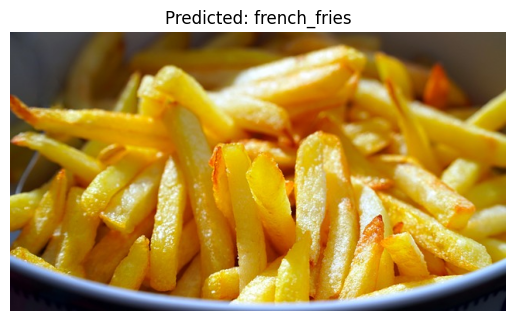

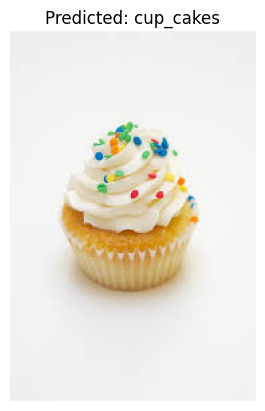

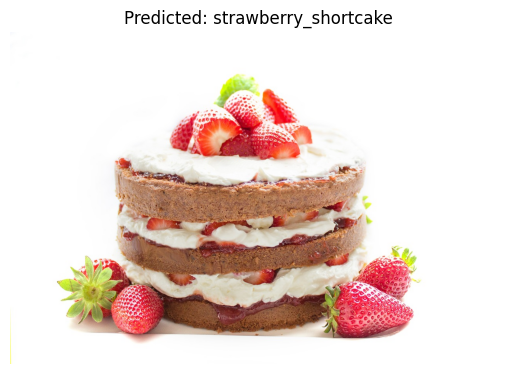

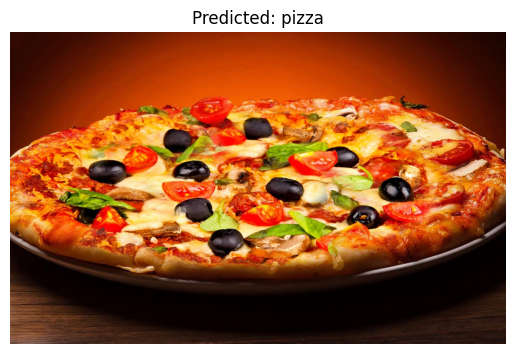

In [50]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model_trained_101class.hdf5')

# Function to load and preprocess images
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Directory containing test images
image_folder = 'test_images'  # Update this to your folder path
target_size = (height, width)  # Use the same dimensions as your model

# Prepare to store images and their paths
images = []
image_paths = []

# Load and preprocess all images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img_array = load_and_preprocess_image(img_path, target_size)
        images.append(img_array)
        image_paths.append(img_path)

# Stack all images into a single array
images = np.vstack(images)

# Make predictions
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Get class indices from train generator
class_indices = train_gen.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse the dictionary

# Map predictions to class labels
predicted_labels = [class_labels[class_idx] for class_idx in predicted_classes]

# Visualize results
for i, img_path in enumerate(image_paths):
    plt.figure()
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()

